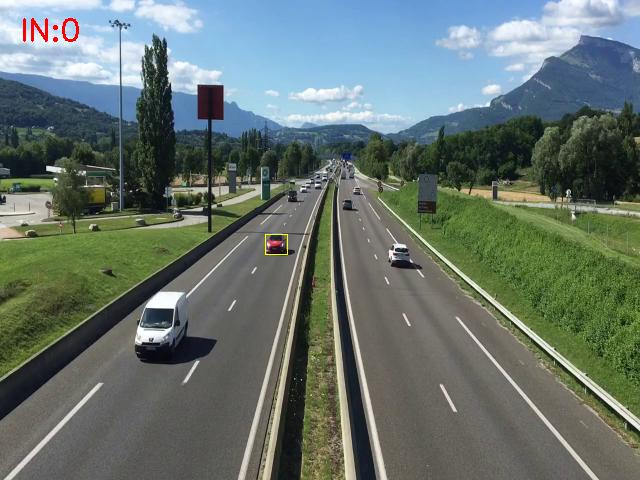

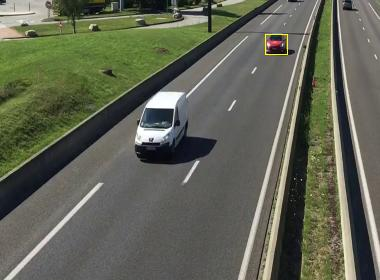

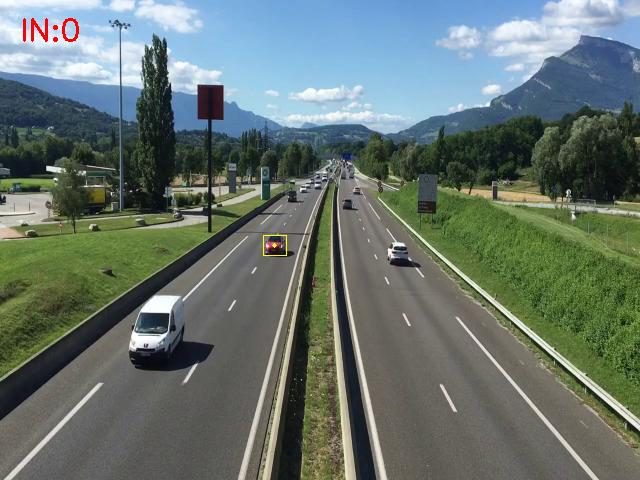

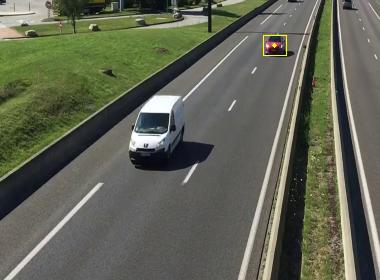

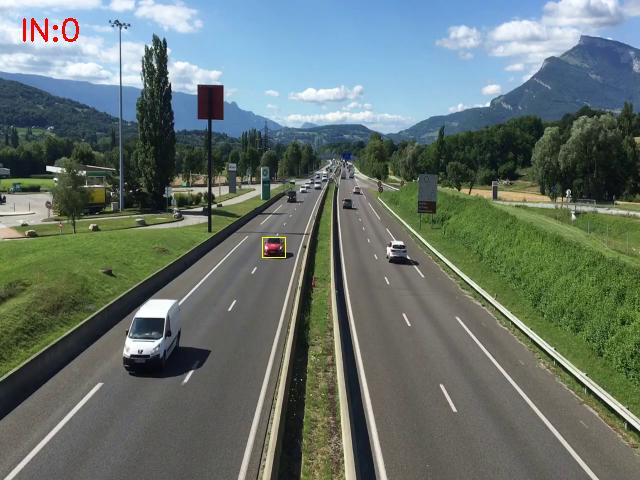

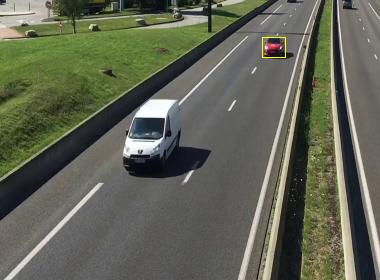

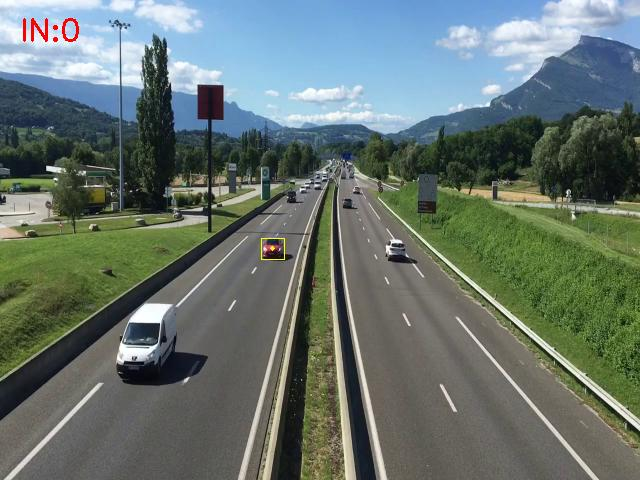

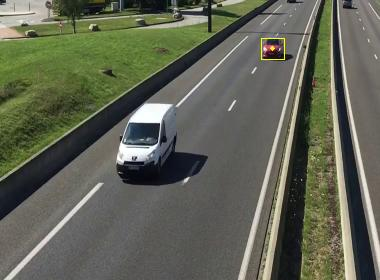

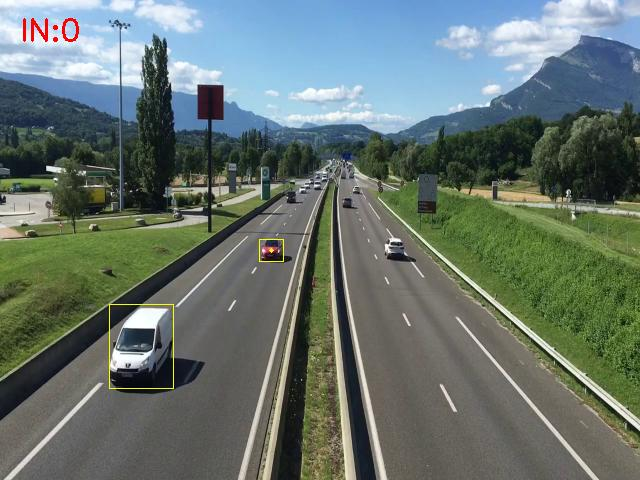

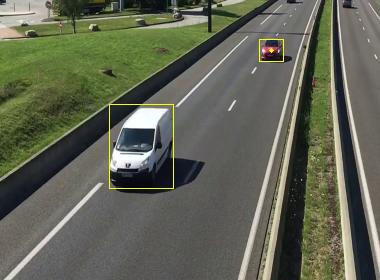

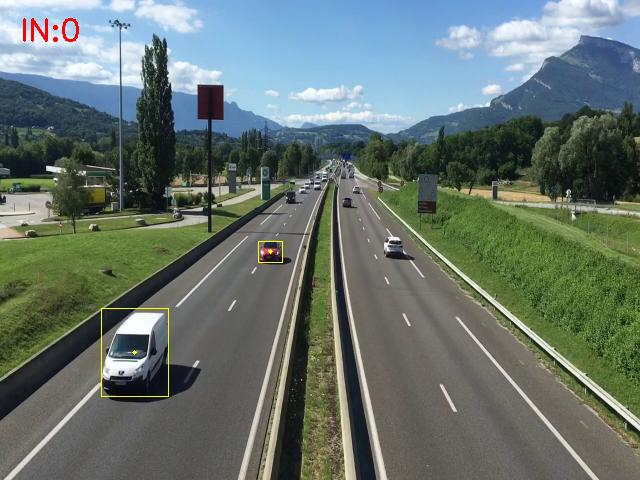

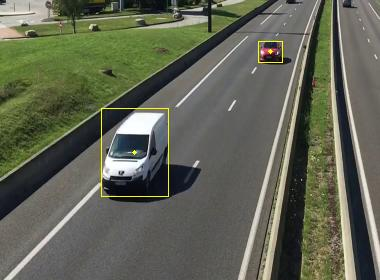

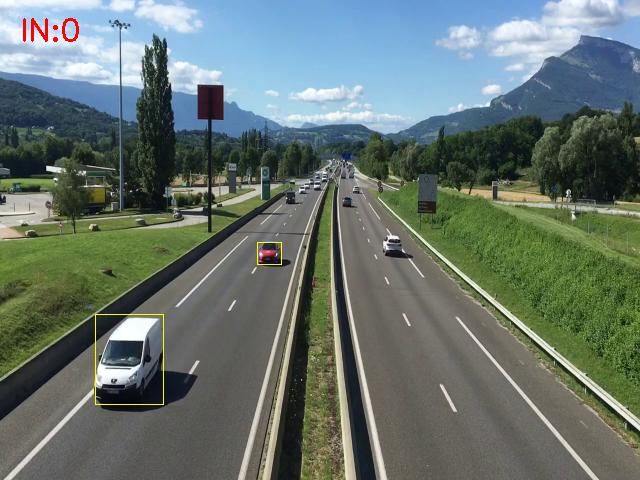

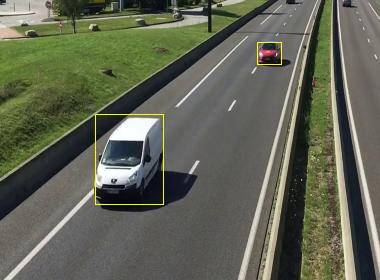

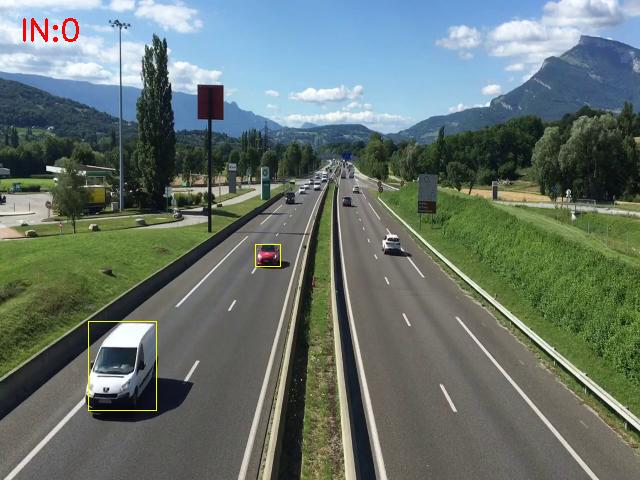

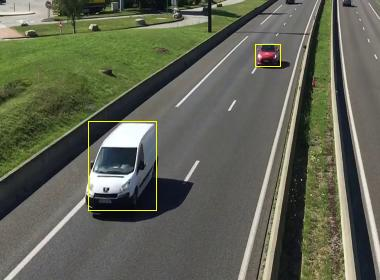

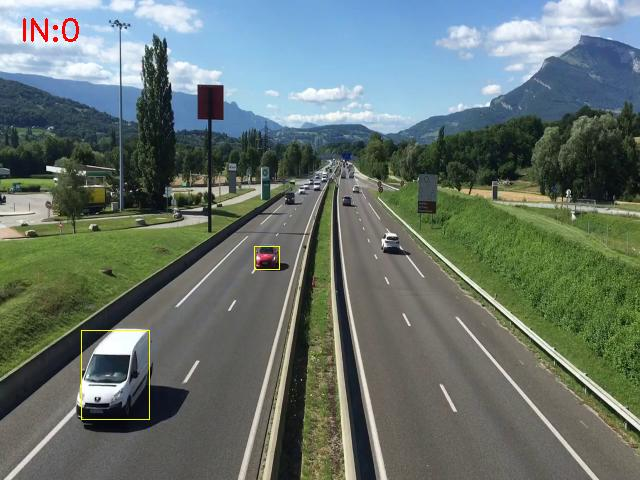

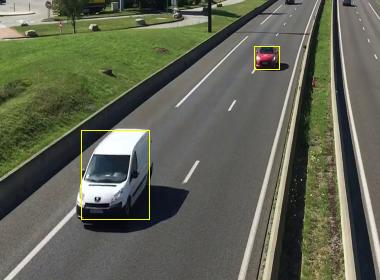

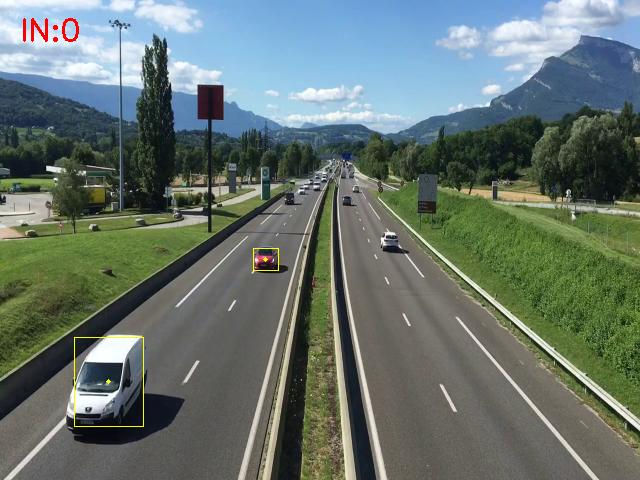

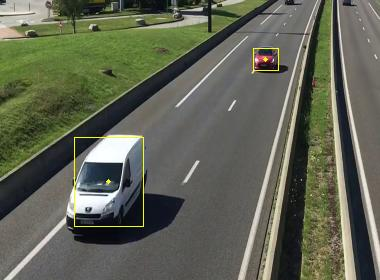

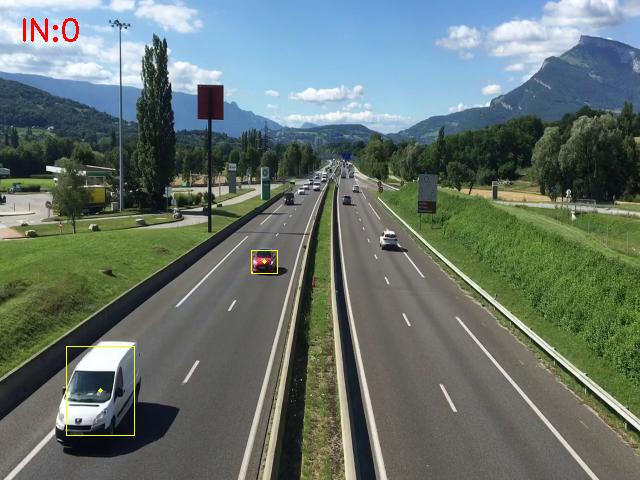

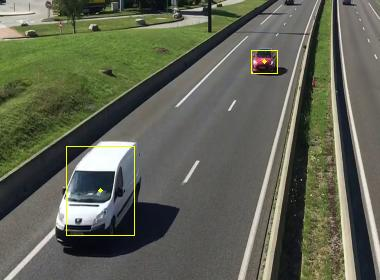

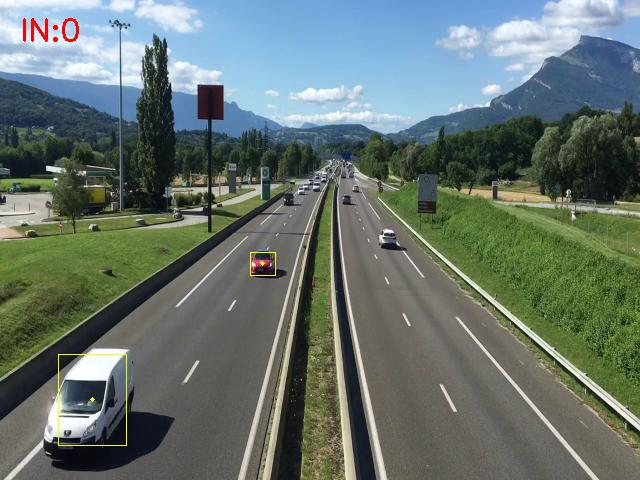

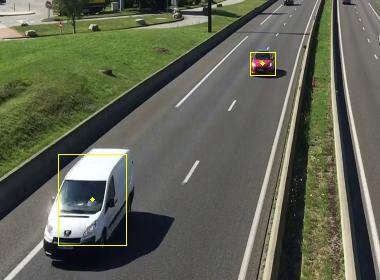

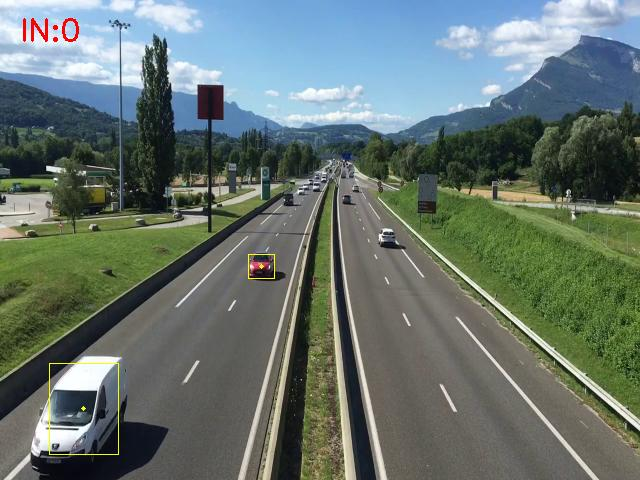

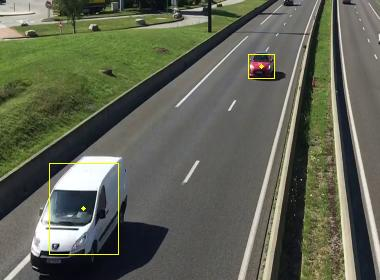

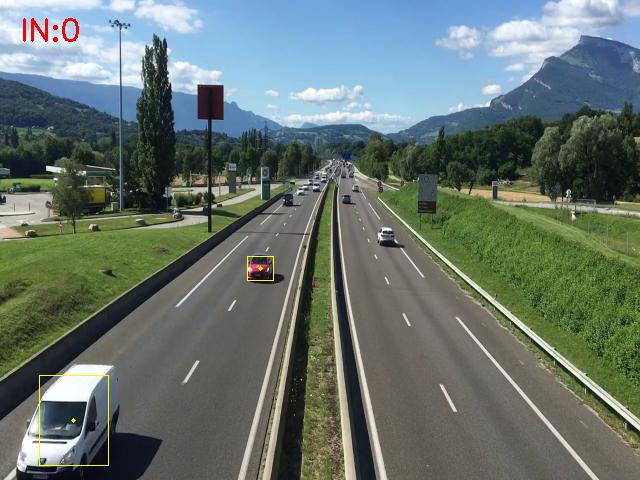

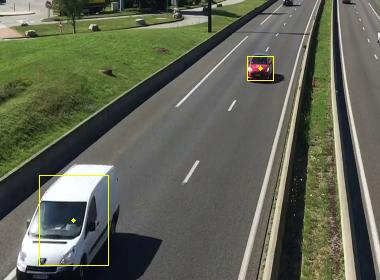

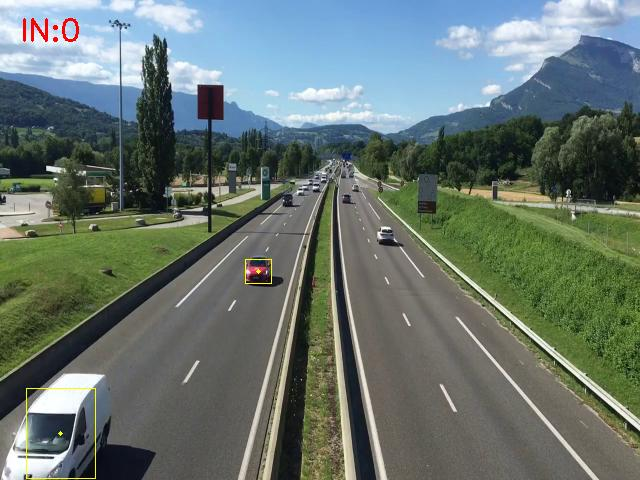

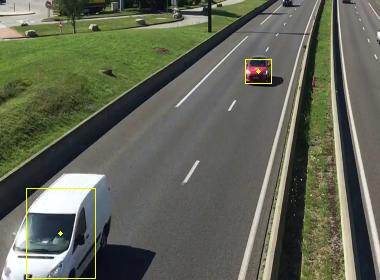

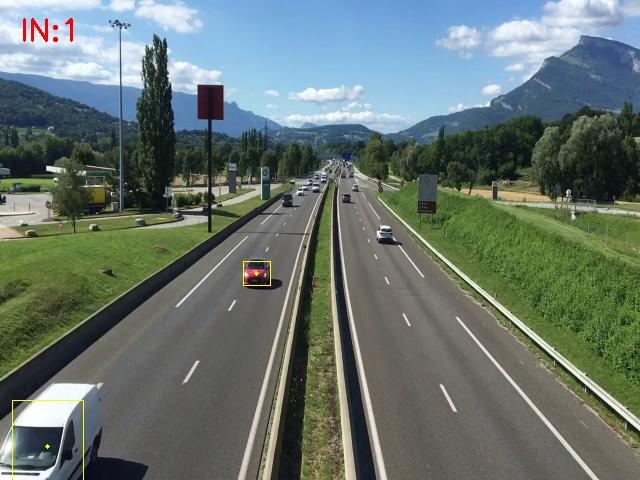

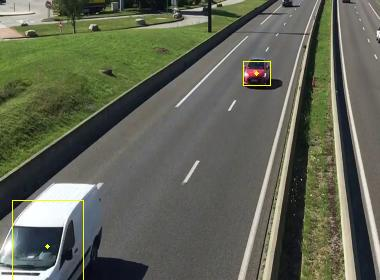

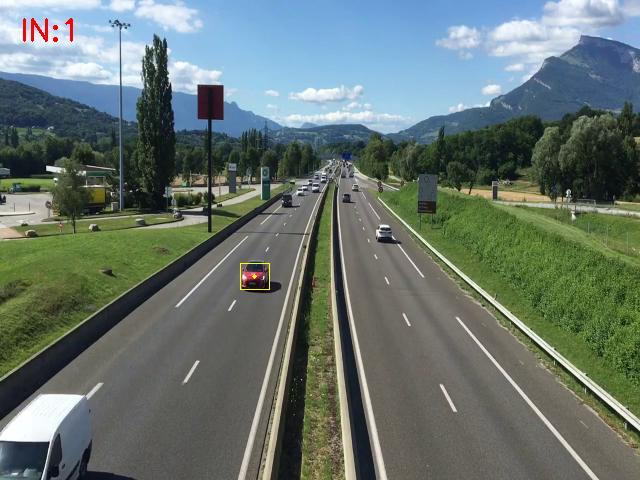

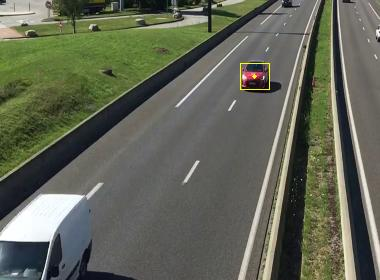

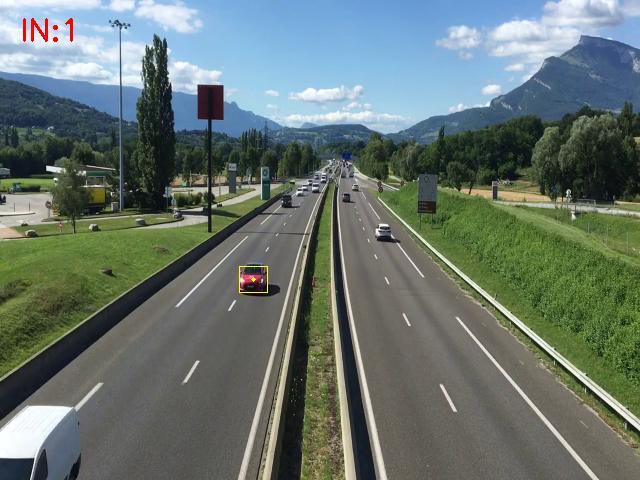

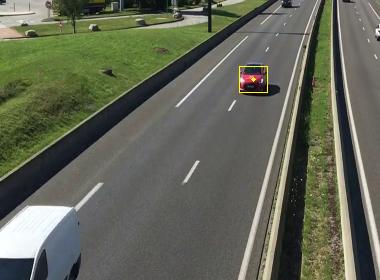

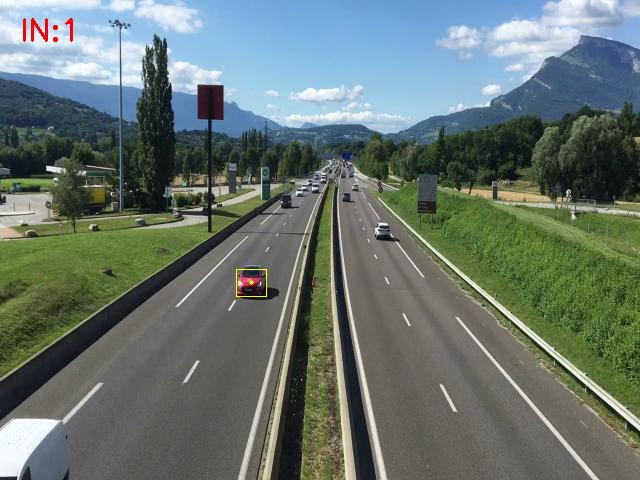

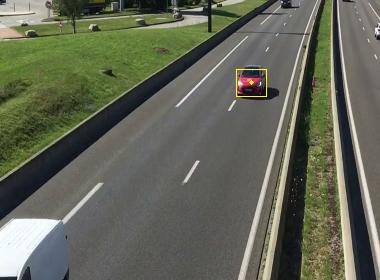

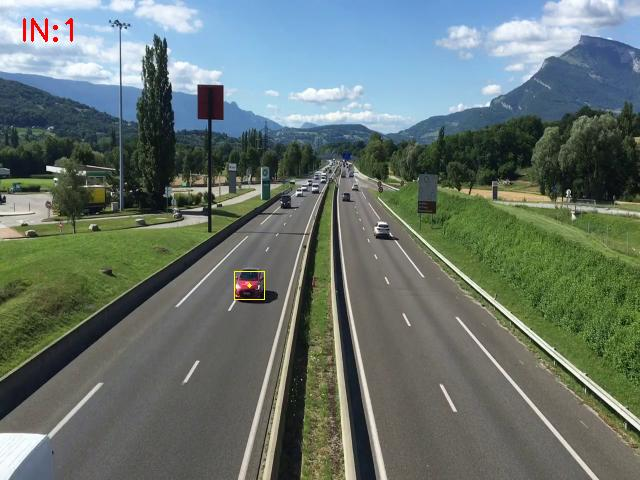

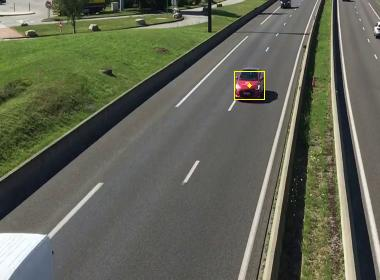

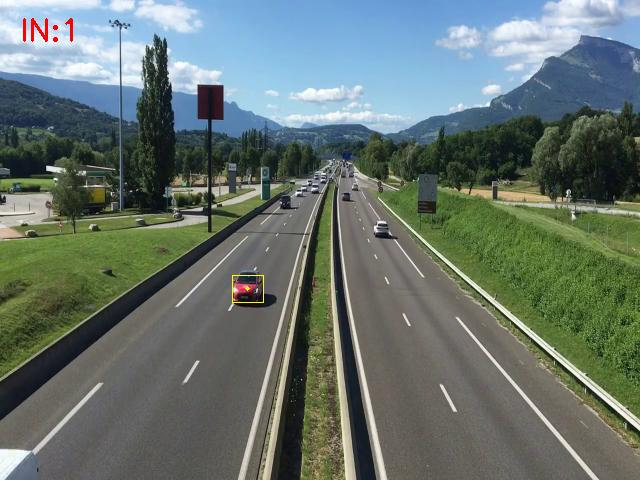

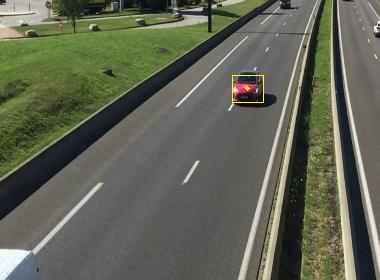

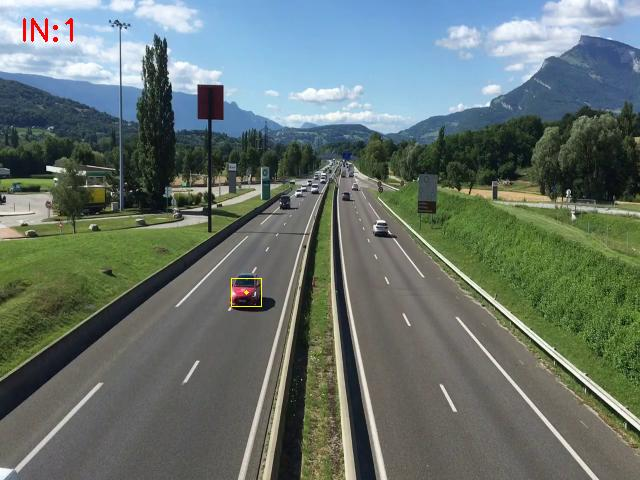

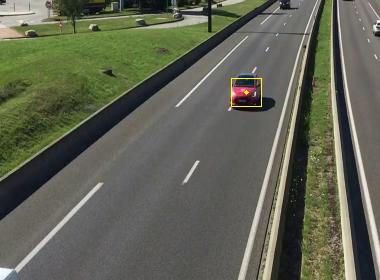

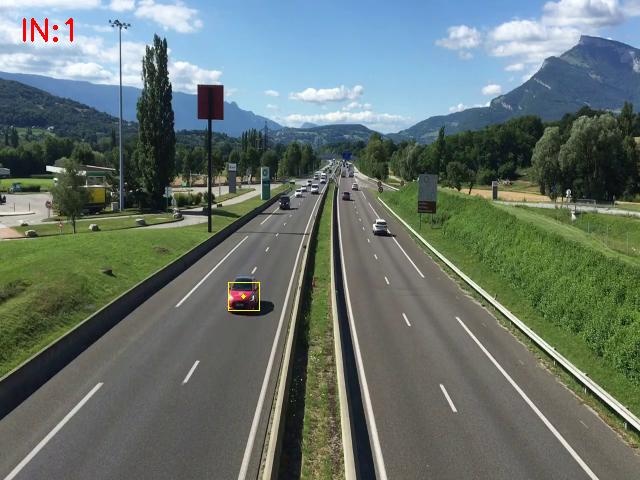

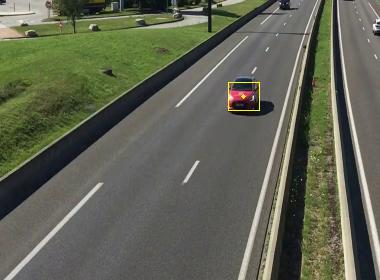

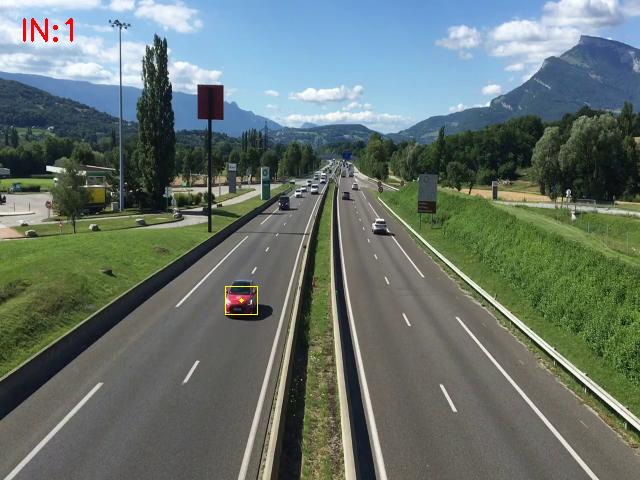

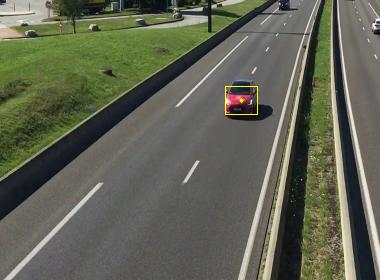

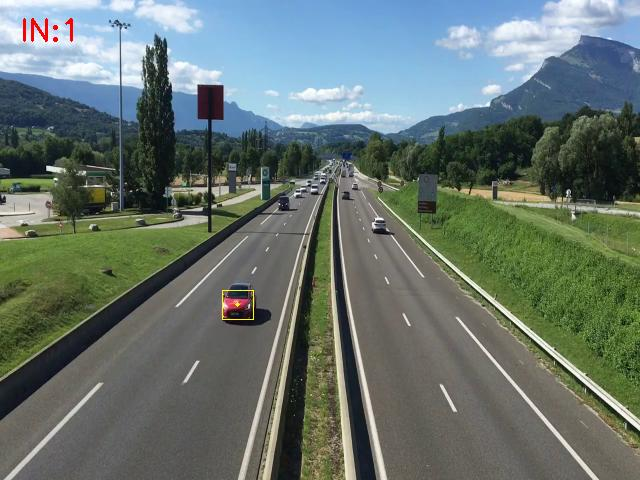

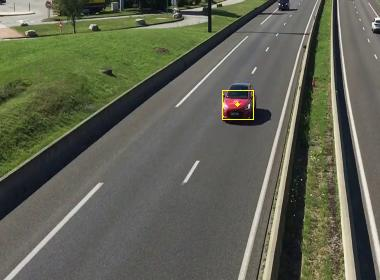

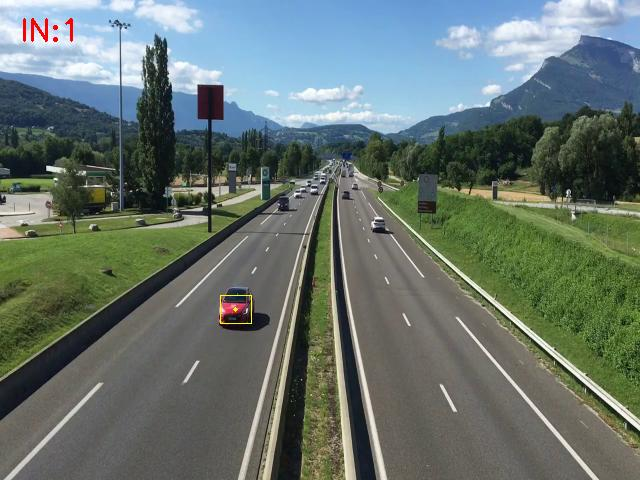

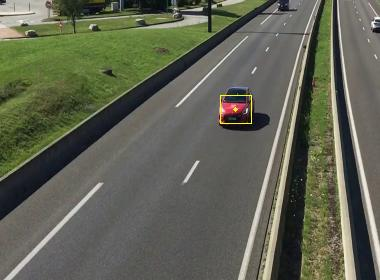

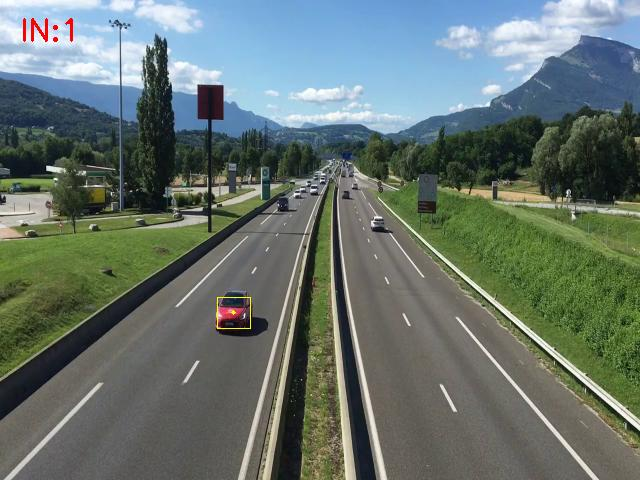

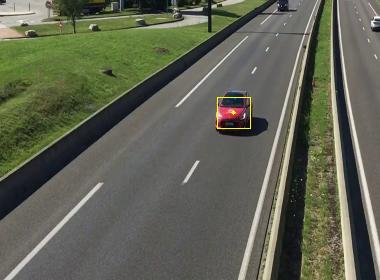

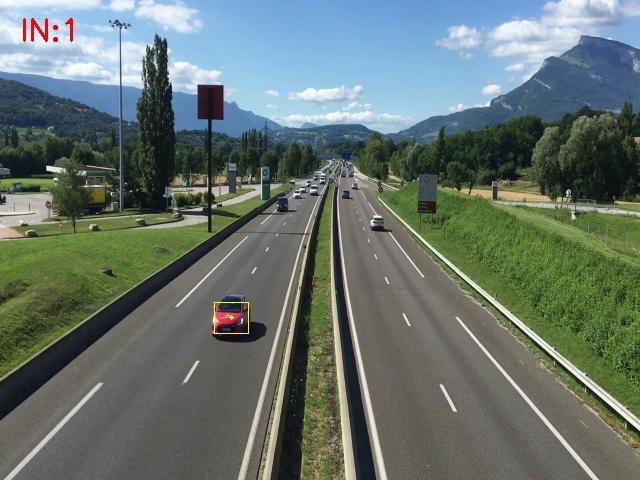

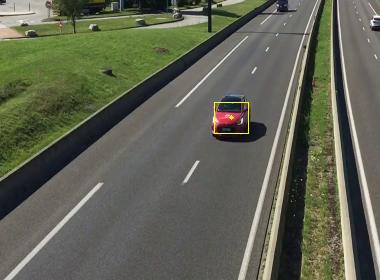

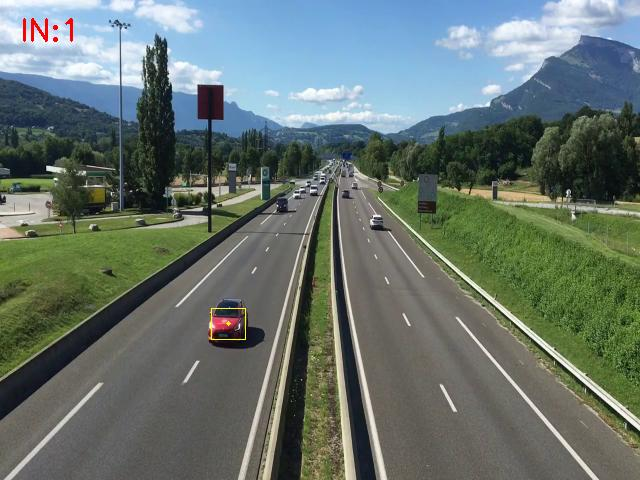

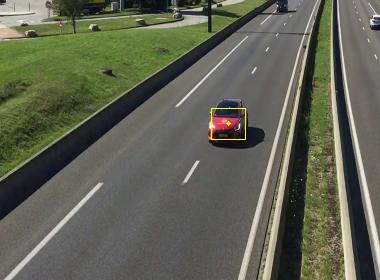

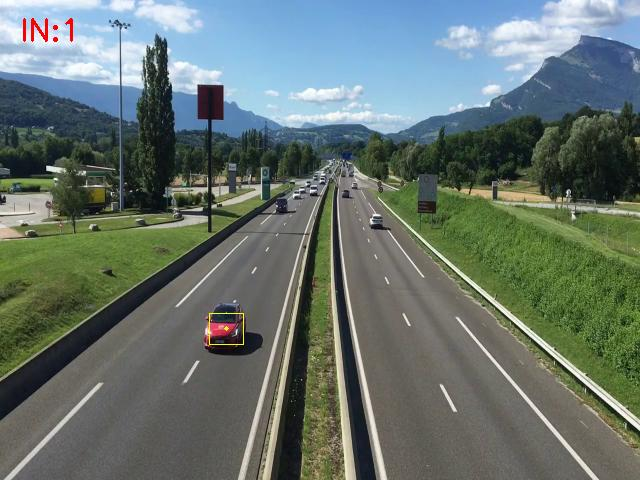

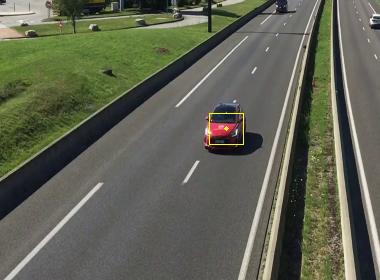

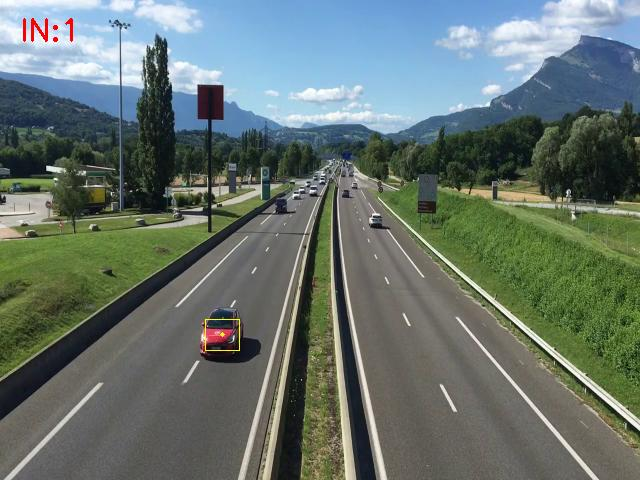

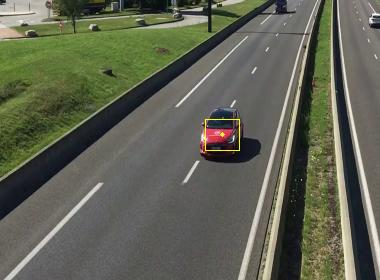

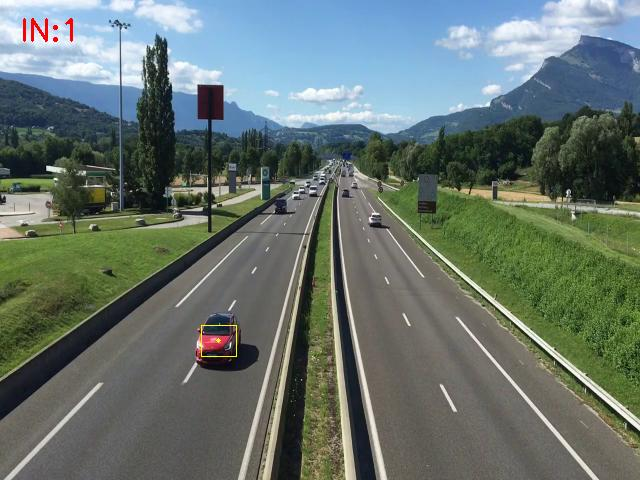

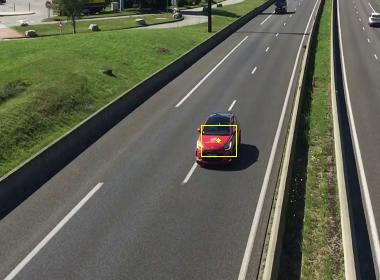

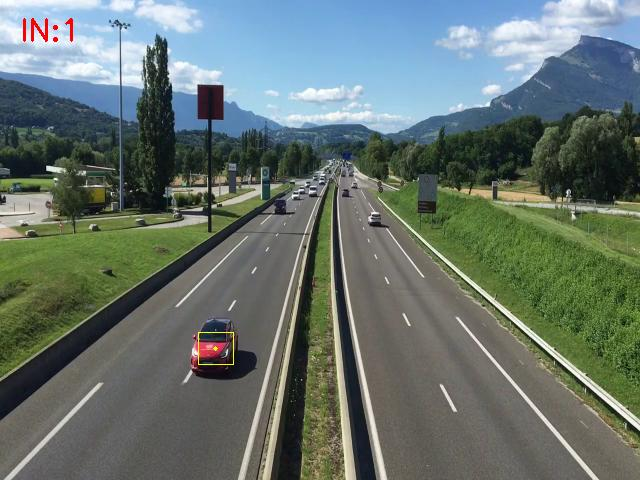

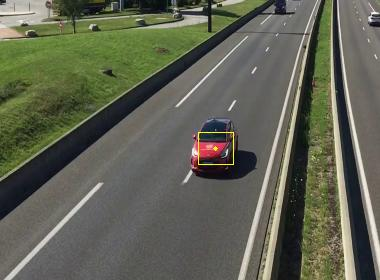

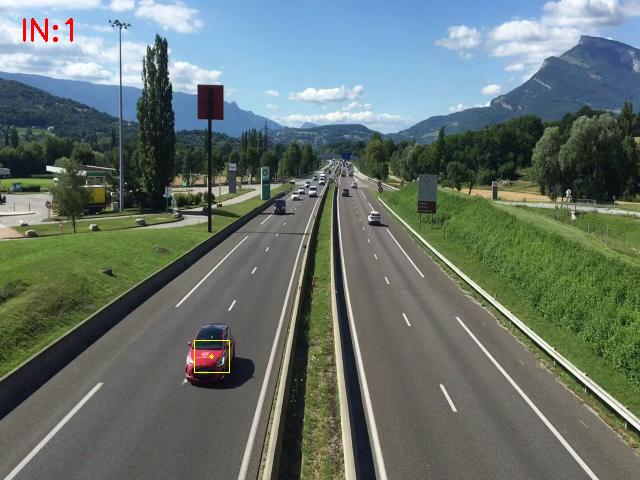

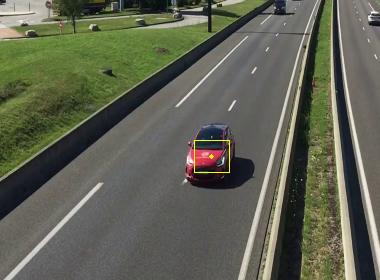

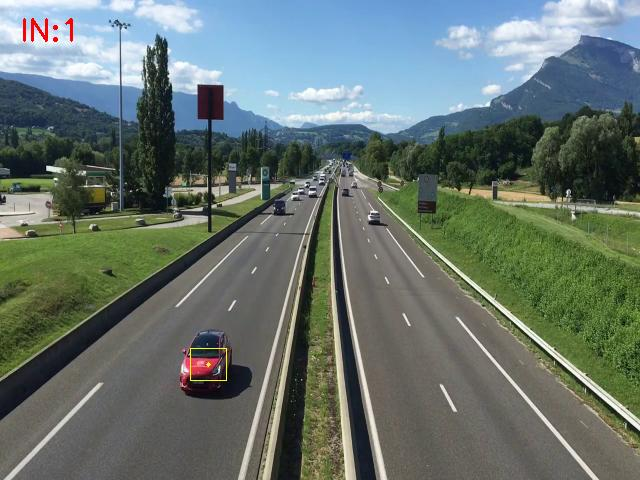

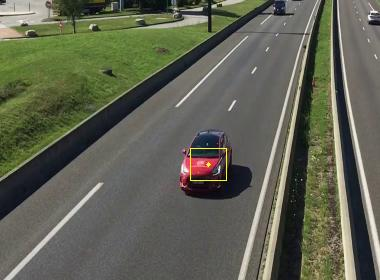

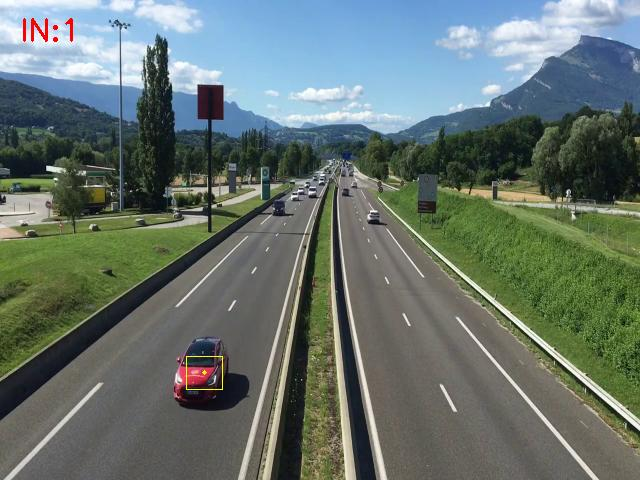

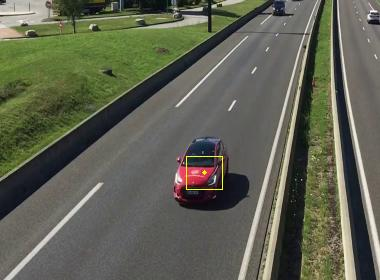

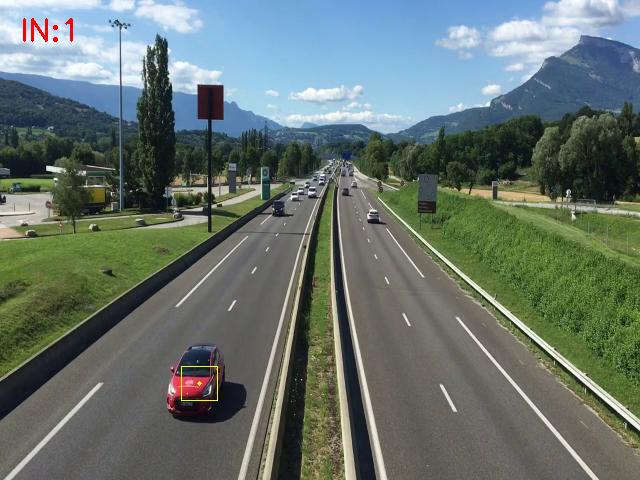

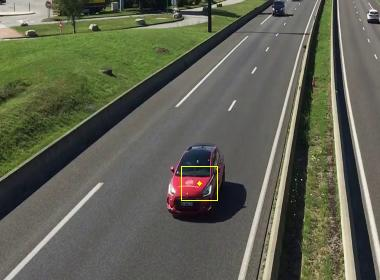

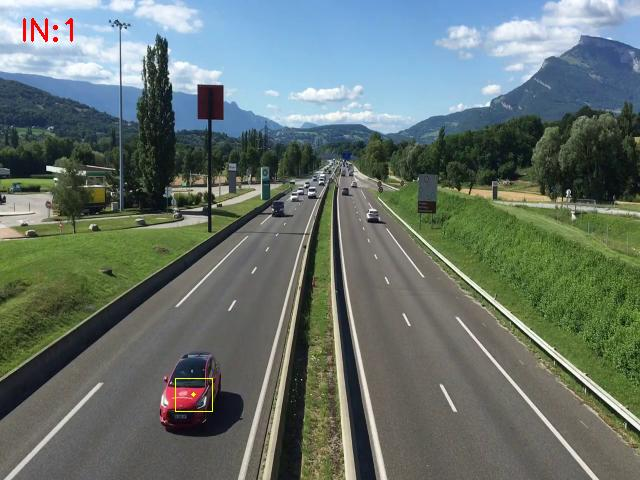

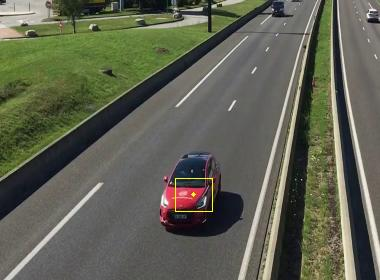

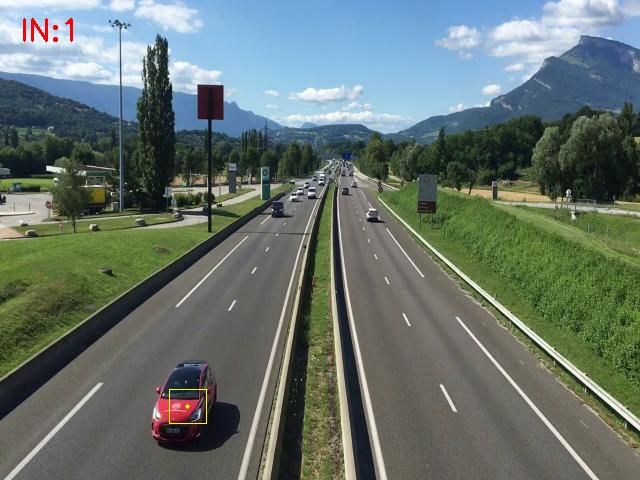

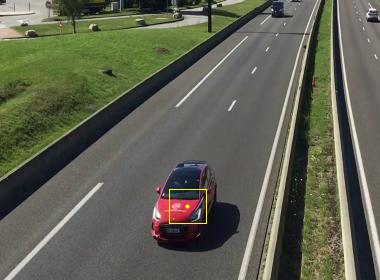

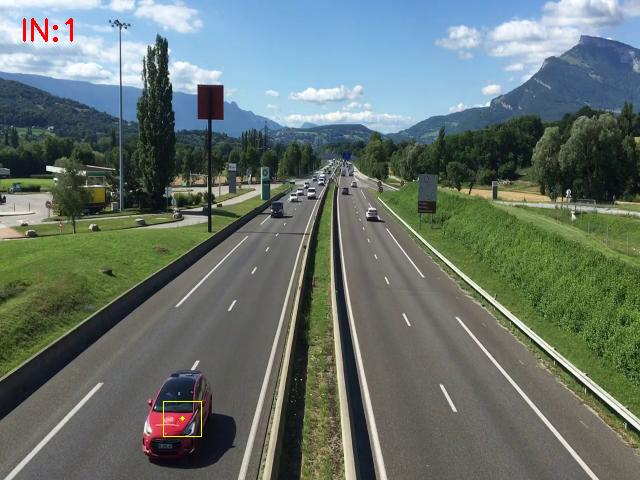

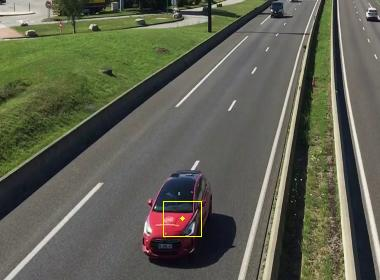

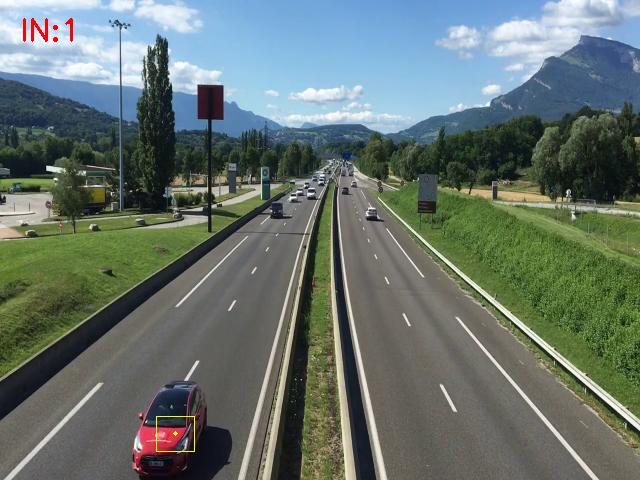

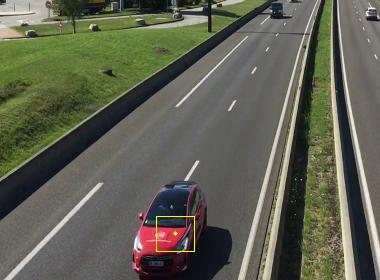

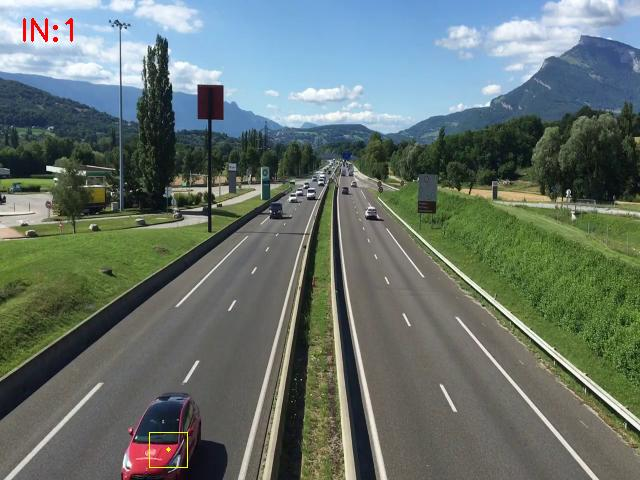

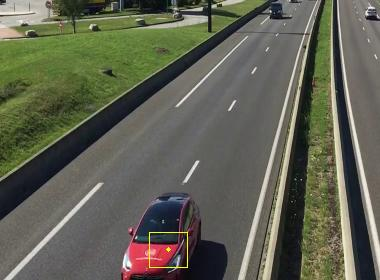

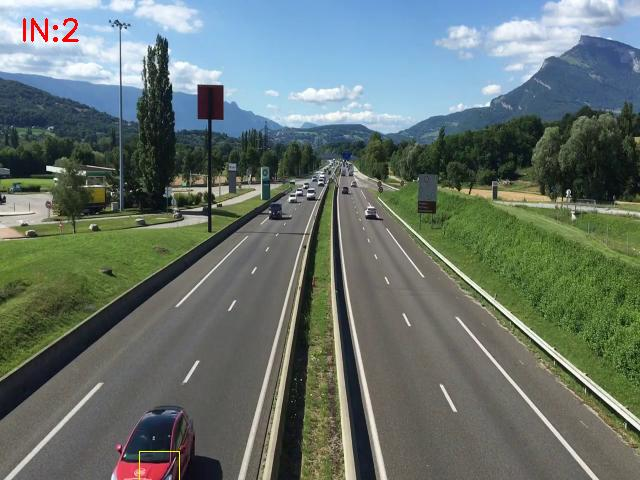

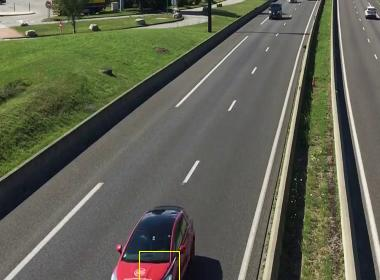

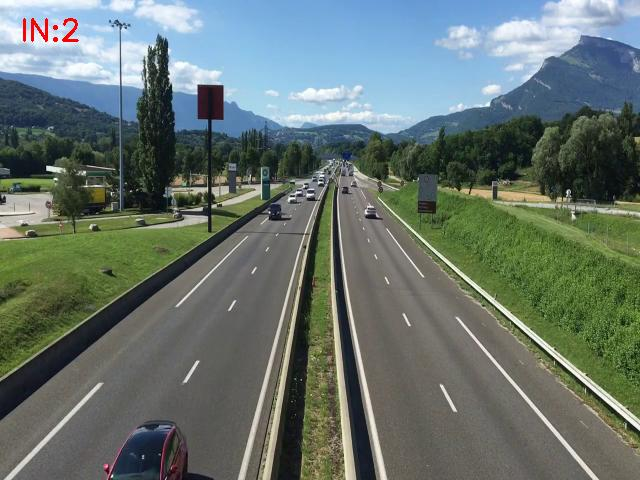

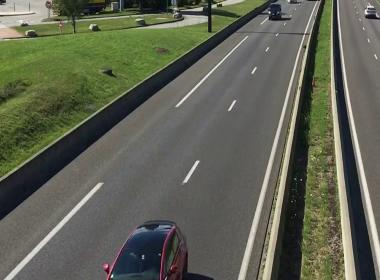

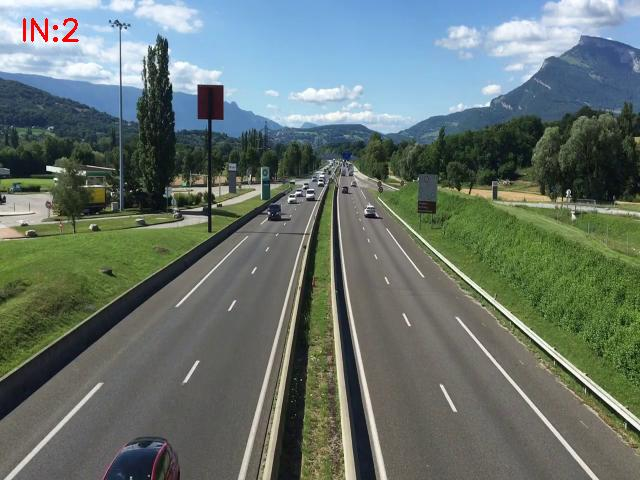

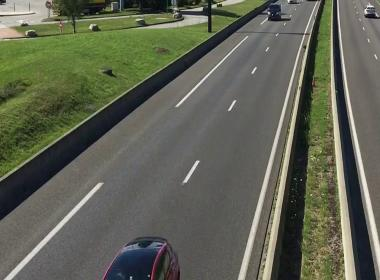

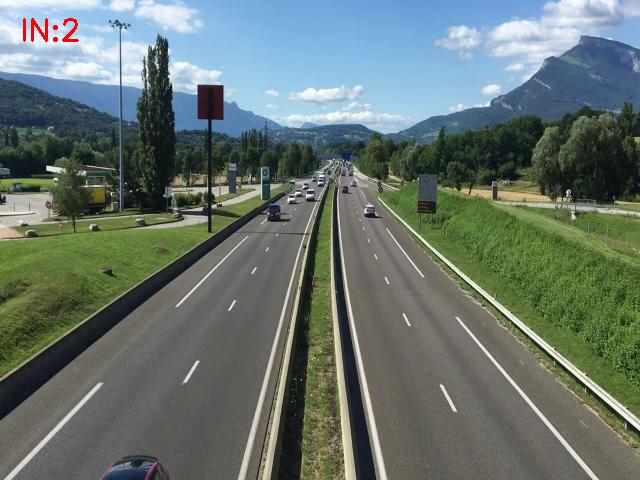

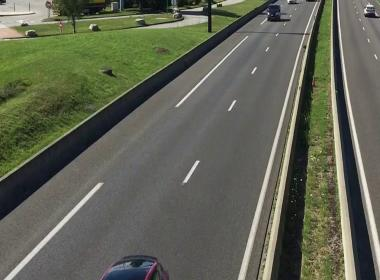

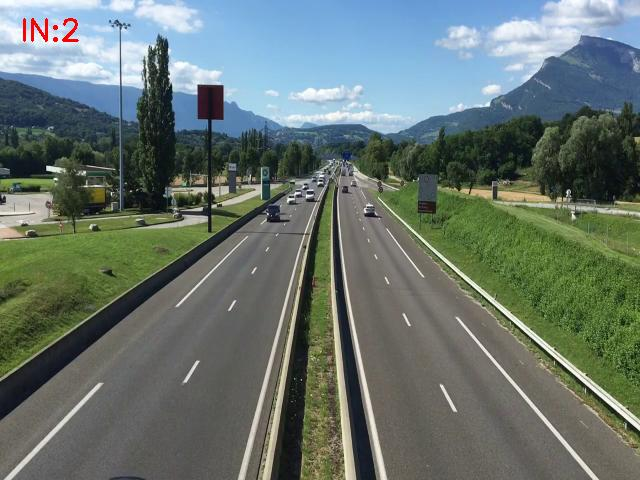

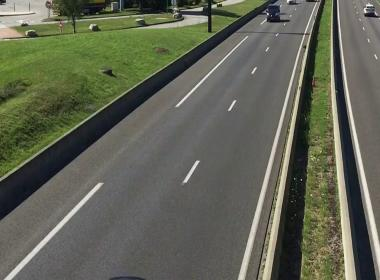

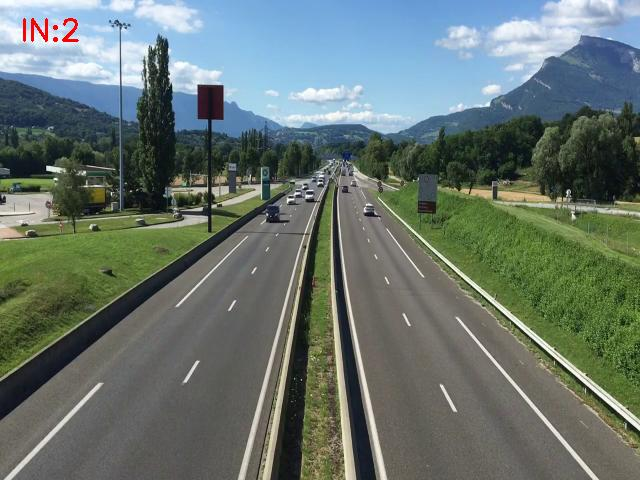

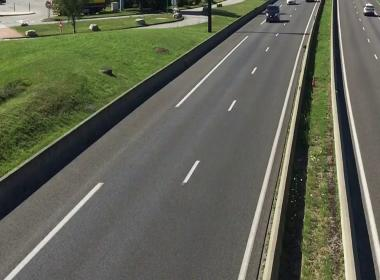

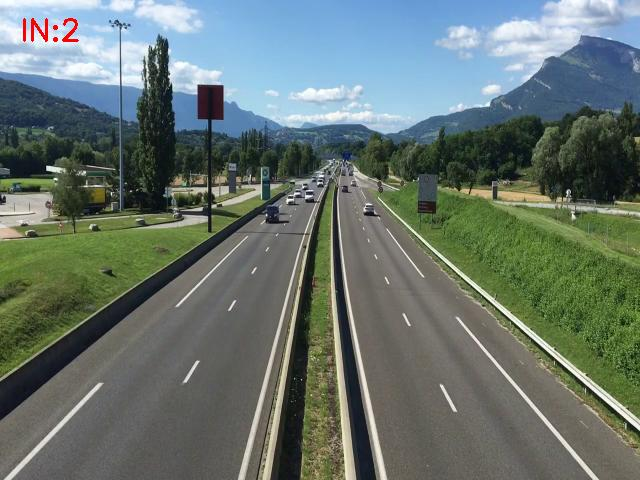

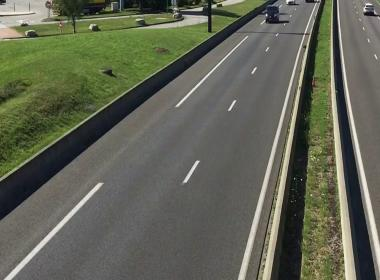

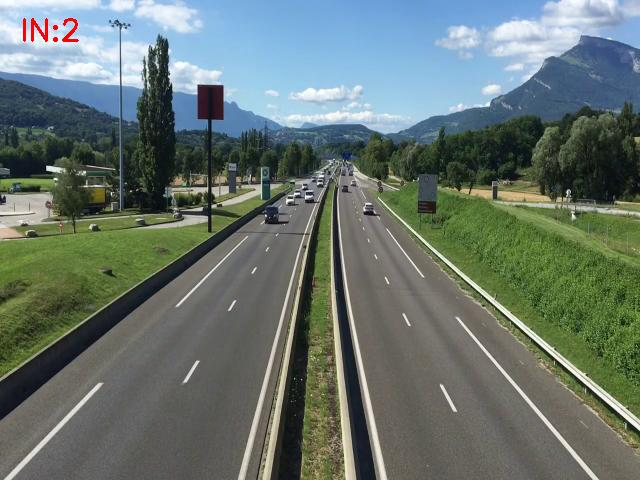

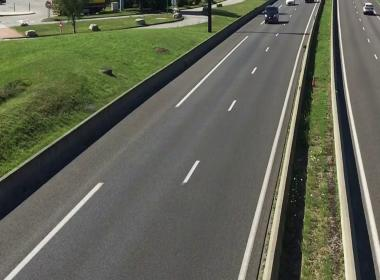

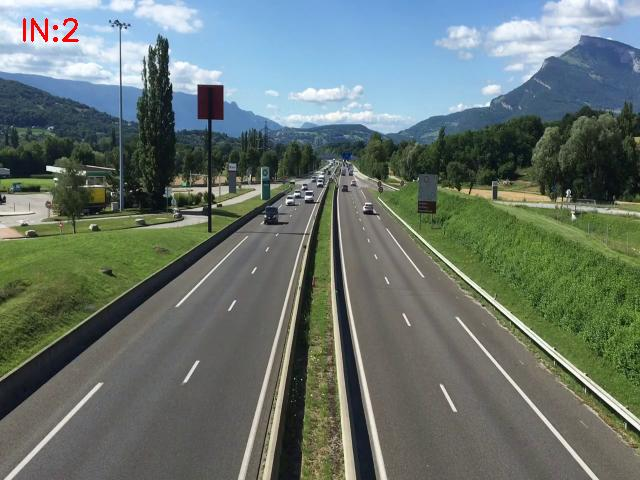

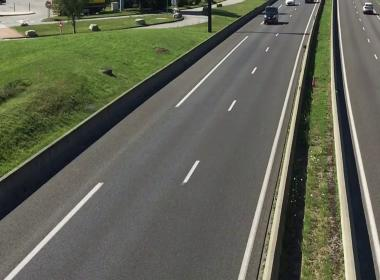

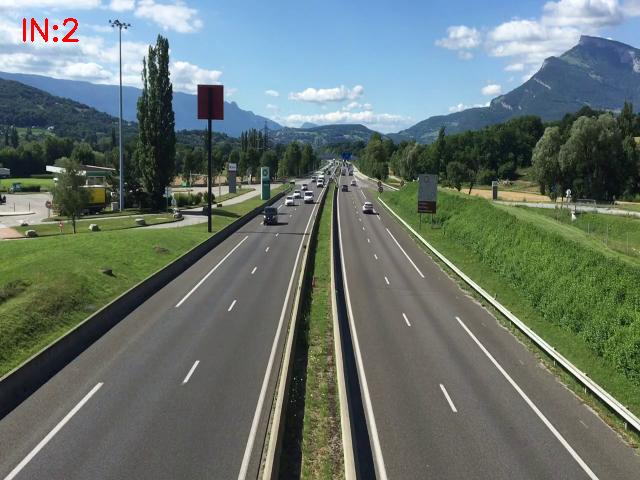

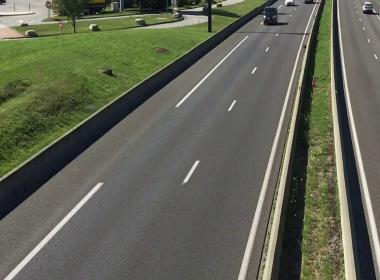

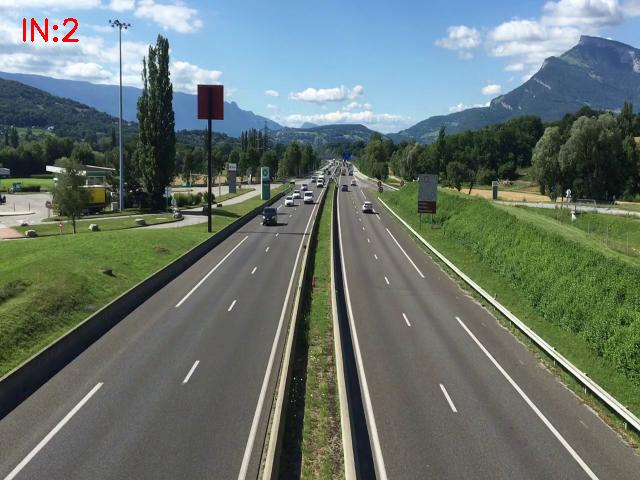

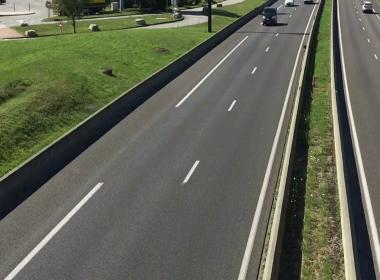

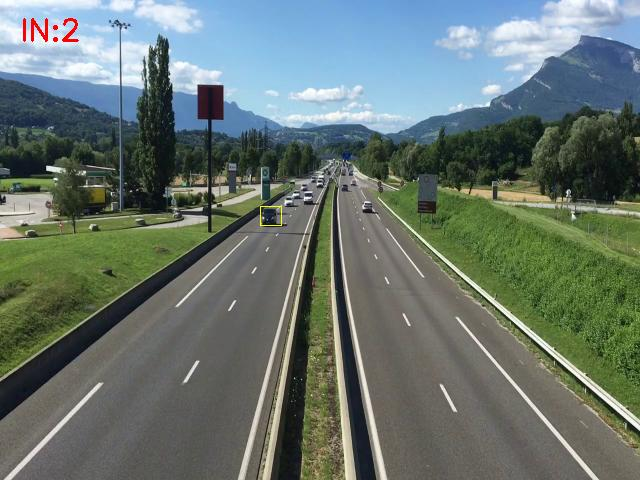

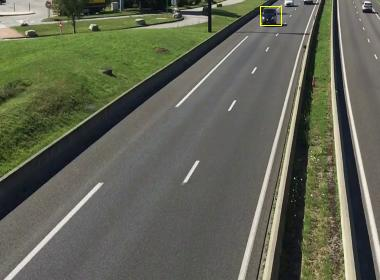

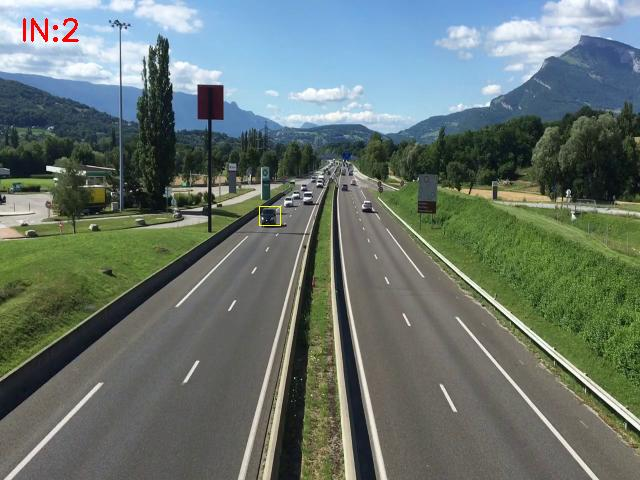

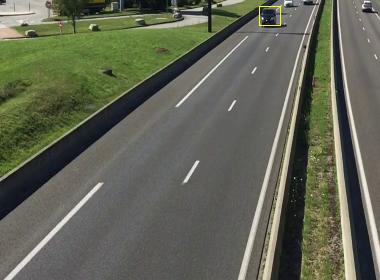

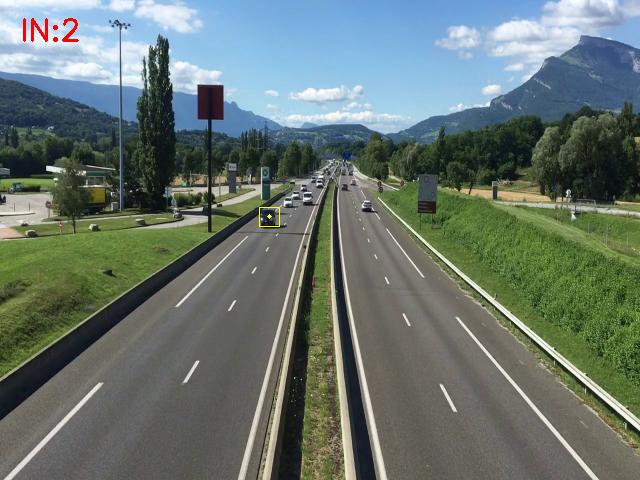

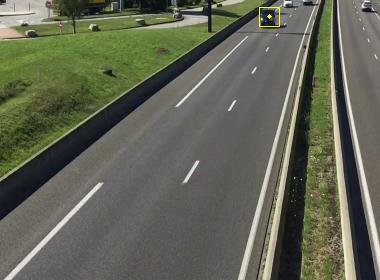

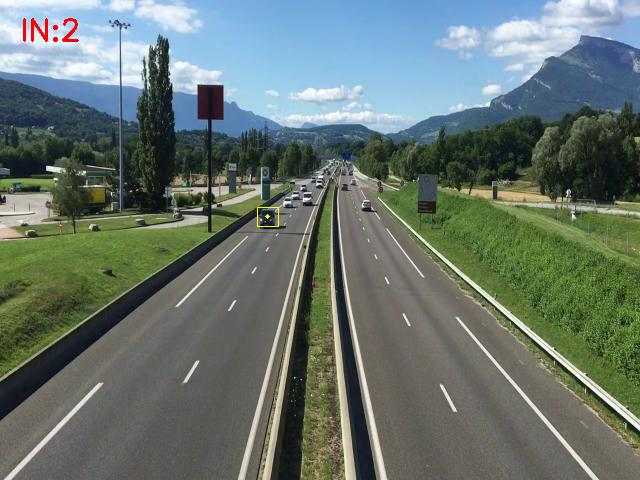

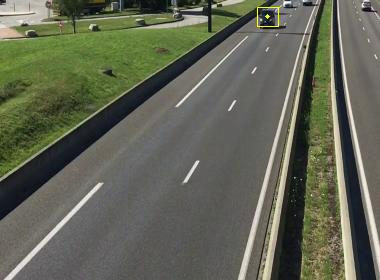

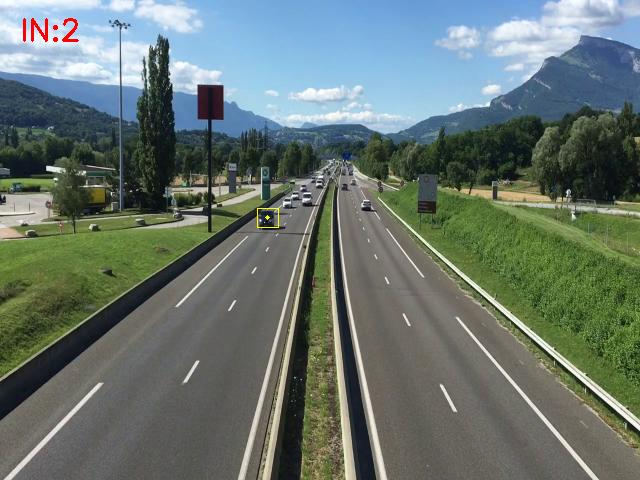

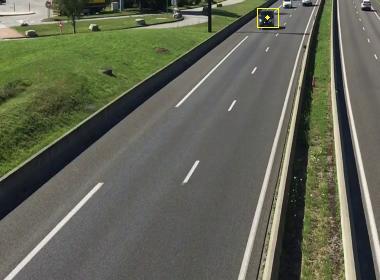

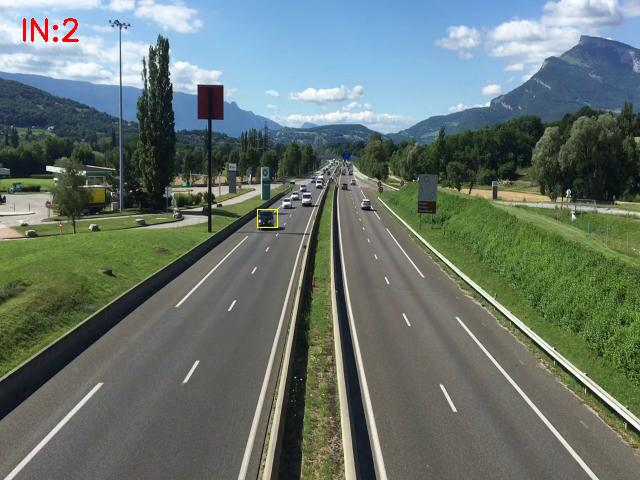

Buffered data was truncated after reaching the output size limit.

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import dlib
trackers=[]

# Initialize the parameters
confidence_threshold = 0.5  # Confidence threshold
nms_threshold = 0.5   # Non-maximum suppression threshold
inp_width = 450       # Width of network's input image
inp_height = 450     # Height of network's input image

classesFile = "coco.names";
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

modelConfig = "yolov4-tiny.cfg";
modelWts = "yolov4-tiny.weights";


net = cv2.dnn.readNetFromDarknet(modelConfig, modelWts)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)


def pointInRect(x,y,w,h,c_x,c_y):
    if (x < c_x and c_x < x+w):
        if (y < c_y and c_y < y+h):
            return True
    else:
        return False

cap = cv2.VideoCapture('highway.mp4')


# Remove the bounding boxes with low confidence using non-maxima suppression
def process(frame, outs):
    global inCount

    frame_h = frame_cropped.shape[0]
    frame_w = frame_cropped.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIDs = []
    confidence_array = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            ID = np.argmax(scores)
            confidence = scores[ID]
            if confidence > confidence_threshold:
                c_x = int(detection[0] * frame_w)
                c_y = int(detection[1] * frame_h)
                w = int(detection[2] * frame_w)
                h = int(detection[3] * frame_h)
                l = int(c_x - w / 2)
                t = int(c_y - h / 2)
                classIDs.append(ID)
                confidence_array.append(float(confidence))
                boxes.append([l, t, w, h])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidence_array, confidence_threshold, nms_threshold)

    trackers_to_del=[]

    # Delete lost trackers based on tracking quality
    for _,tracker_ids in enumerate(trackers):
        tracking_quality = tracker_ids[0].update(frame_cropped)
        if tracking_quality < 5:
            trackers_to_del.append(tracker_ids[0])

    for index in trackers_to_del:
        trackers.pop(index)


    for i in indices:
        box = boxes[i]
        l = box[0]
        t = box[1]
        w = box[2]
        h = box[3]
        classId, conf, l, t, r, b = classIDs[i], confidence_array[i], l, t, l + w, t + h

        rect = dlib.rectangle(l,t,r,b)
        x = rect.left()
        y = rect.top()
        w = rect.right() - x
        h = rect.bottom() - y

        tracking = False

        for tracker_ids in trackers:
            pos = tracker_ids[0].get_position()
            startX = int(pos.left())
            startY = int(pos.top())
            endX = int(pos.right())
            endY = int(pos.bottom())
            c_x = int((startX+endX)/2)
            c_y = int((startY+endY)/2)
            cv2.circle(frame_cropped, (c_x, c_y),2, (25,250,250), -1)
            t_location_chk = pointInRect(x,y,w,h,c_x,c_y)
            if t_location_chk:
                tracking = True

        if not tracking:
            tracker = dlib.correlation_tracker()
            tracker.start_track(frame_cropped, rect)
            trackers.append([tracker,frame_cropped])

    for num,tracker_ids in enumerate(trackers):
        pos = tracker_ids[0].get_position()
        (startX, startY, endX, endY) = (int(pos.left()), int(pos.top()), int(pos.right()), int(pos.bottom()))
        cv2.rectangle(frame_cropped, (startX, startY), (endX, endY),(0, 255, 250), 1)
        if endX<380 and endY>=280:
            inCount+=1
            trackers.pop(num)




inCount= 0
while True :

    # get frame from the video
    _, frame = cap.read()
    frame_resized = cv2.resize(frame,(640,480))
    frame_cropped=frame_resized[200:640,0:380]
    blob = cv2.dnn.blobFromImage(frame_cropped, 1/255, (inp_width, inp_height), [0,0,0], 1, crop=False)
    net.setInput(blob)
    layers = net.getLayerNames()
    unconnected_layers =  [layers[i-1] for i in net.getUnconnectedOutLayers()]
    outputs = net.forward(unconnected_layers)

    # Remove the bounding boxes with low confidence
    process(frame_cropped, outputs)

    cv2.putText(frame_resized,f"IN:{inCount}",
                    (20,40),0,1,(0,0,255),2)


    cv2_imshow(frame_resized)
    cv2_imshow(frame_cropped)
